# Tissue preparation

## Notebook Purpose
This notebook focuses on isolating individual tissue regions from WSI (Whole Slide Images) and preparing them for further image alignment and morphing. The pipeline includes tissue segmentation using color deconvolution (H&E), bounding box extraction, and masking techniques to separate and clean distinct tissue slices. The goal is to produce standardized, high-quality tissue crops for reliable feature extraction and mapping in later stages of the project.

## Imports

### Overview
- OpenSlide: Reading multi-resolution Whole Slide Images (.mrxs).
- scikit-image (rgb2hed, hed2rgb): H&E color deconvolution for tissue segmentation.
- NumPy: Numerical operations on image arrays.
- OpenCV (cv2): Image processing (thresholding, contour detection).
- Pillow (PIL): Image conversion and manipulation.

In [ ]:
import openslide
import cv2
from PIL import Image
from skimage.color import hed_from_rgb
from skimage.color import rgb2hed, hed2rgb

import matplotlib.pyplot as plt
import numpy as np

import pickle
import os
from tissue_classes import Slide, Tissue

## First look

### Data description
The dataset consists of two high-resolution Whole Slide Images (WSIs) in .mrxs format, representing consecutive histological cross-sections of human colon tissue:

- 1M01.mrxs: Contains 3 tissue fragments of one morphological type.
- 1M02.mrxs: Contains 4 tissue fragments of a different morphological type.

Each WSI is stained with Hematoxylin and Eosin (H&E), revealing complex tissue structures. Due to the large size and high resolution of the slides, Level of Detail 3 (LOD3) was selected for processing, offering a balance between visual clarity and computational efficiency. This level ensures sufficient detail for accurate tissue detection while reducing processing time and memory usage.

Resolution of image 1: 6885x16607, Channel count: 4
Resolution of image 2: 6885x16607, Channel count: 4


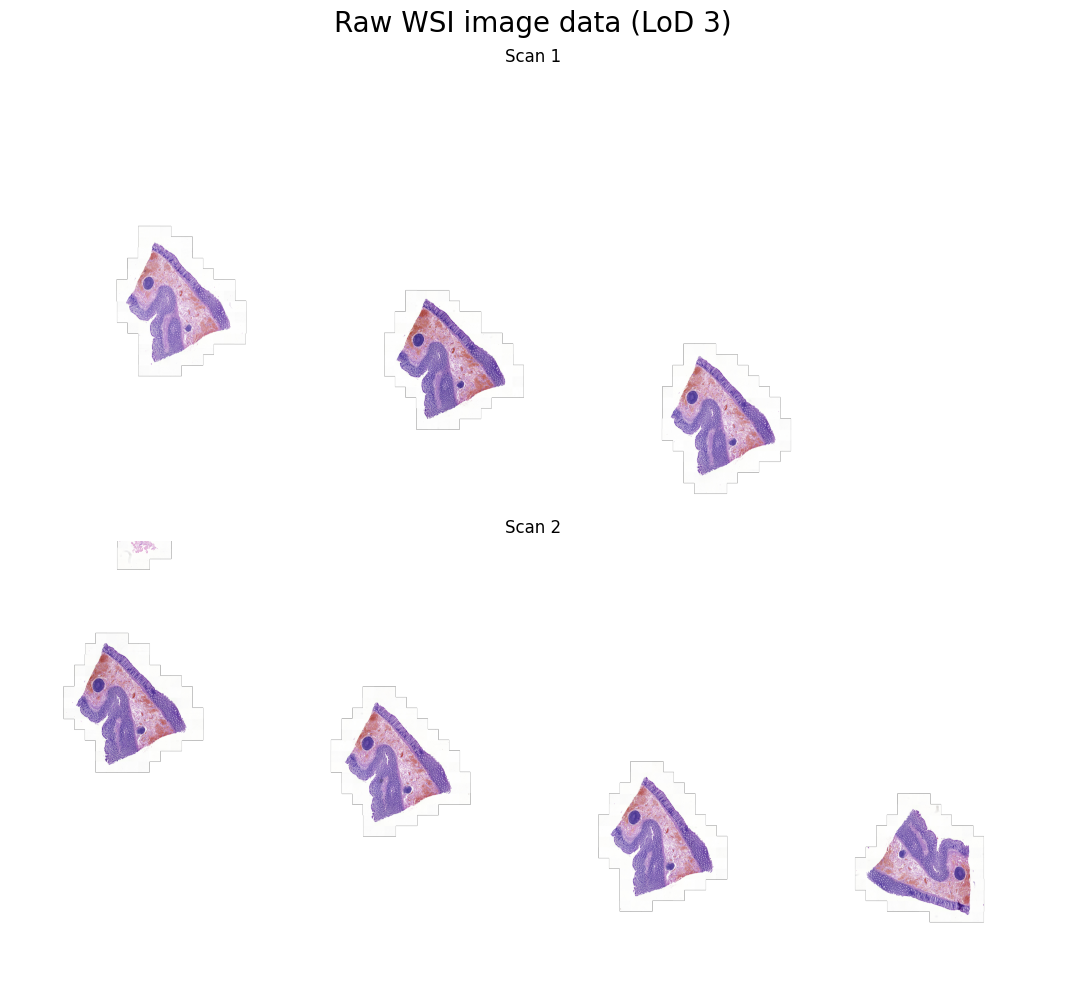

In [2]:
lod = 3

def load_slide(filename, lod, thumbnail=(1000,1000)):
    slide = openslide.OpenSlide(f'../data/WSI_scans/{filename}')
    image = slide.read_region((0, 0), lod, slide.level_dimensions[lod])
    image = image.transpose(method=Image.Transpose.ROTATE_90)
    thumb = slide.get_thumbnail(thumbnail)
    thumb = thumb.transpose(method=Image.Transpose.ROTATE_90)
    return np.array(image), np.array(thumb)

image = [None] * 2
thumbnail = [None] * 2

image[0], thumbnail[0] = load_slide('1M01.mrxs', lod)
image[1], thumbnail[1] = load_slide('1M02.mrxs', lod)

fig, axes = plt.subplots(2,1,figsize=(20, 10))
fig.suptitle(f'Raw WSI image data (LoD {lod})', fontsize=20)

for i in range(len(image)):
    axes[i].imshow(image[i])
    axes[i].set_title(f'Scan {i+1}')
    print(f'Resolution of image {i+1}: {image[i].shape[0]}x{image[i].shape[1]}, Channel count: {image[i].shape[2]}')

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

**Figure:** Visual overview of the tissue content extracted from WSI files at Level of Detail 3 (LOD3). The image displays segmented tissue fragments from both slides, illustrating the morphological diversity and quality of the regions prepared for downstream processing.

## Extraction of samples

Implementation of automated method to detect and extract individual tissue regions from Whole Slide Images using their lower-resolution thumbnails. It applies edge detection and contour analysis to identify bounding boxes around distinct tissue fragments, filtering nested boxes to avoid redundancy. The relative coordinates from the thumbnails are scaled to the full-resolution images to crop precise tissue patches. This approach facilitates downstream processing by isolating clean tissue samples for feature extraction and morphing.

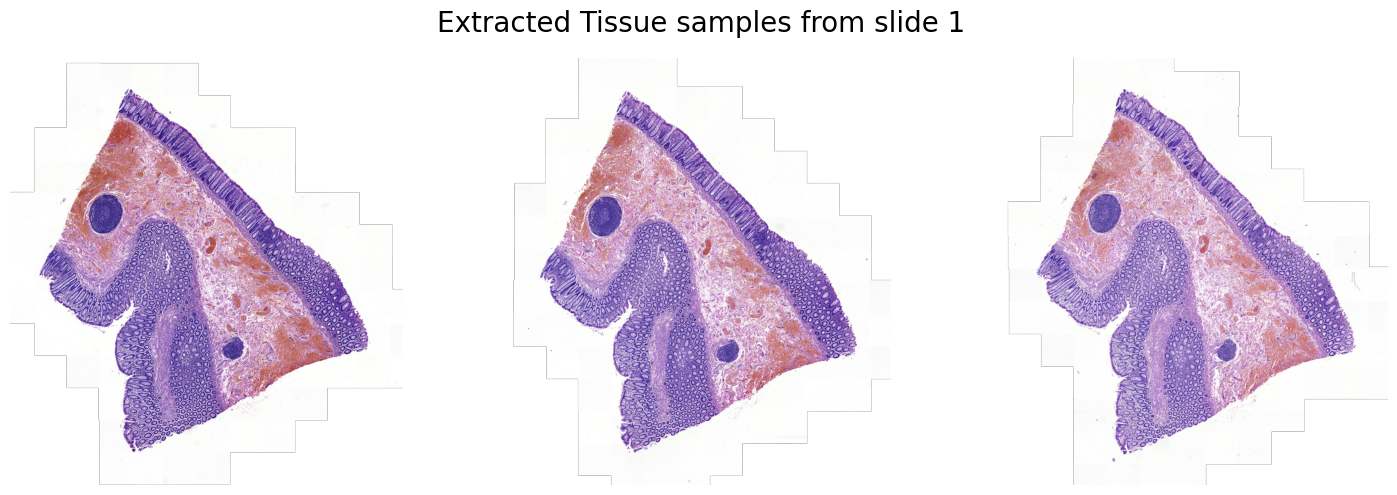

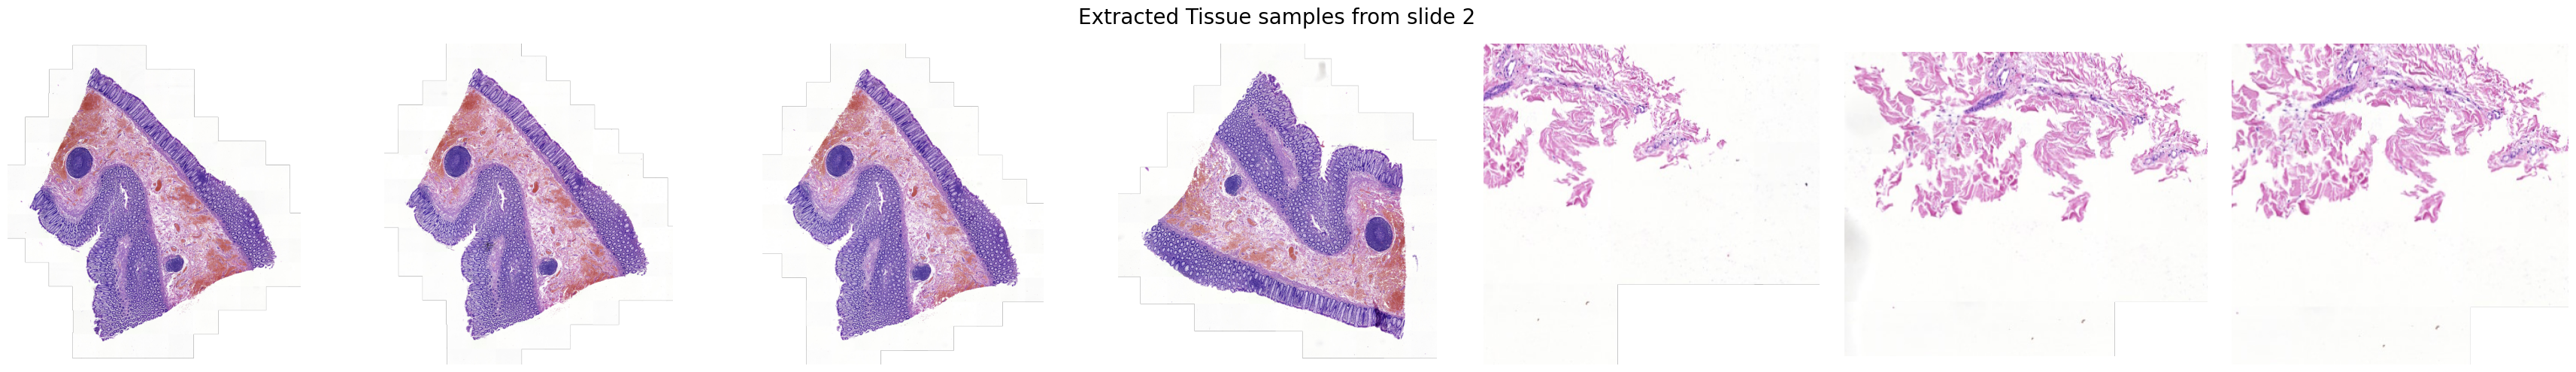

In [ ]:
def extract_tissue_region(thumb: np.ndarray, offset: int = 10) -> list[list]: 
    def contains(rect_a, rect_b):
        x1, y1, w1, h1 = rect_a
        x2, y2, w2, h2 = rect_b
        return x1 <= x2 and y1 <= y2 and x1 + w1 >= x2 + w2 and y1 + h1 >= y2 + h2

    gray = cv2.cvtColor(thumb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 150, 250)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rects = [cv2.boundingRect(c) for c in contours]
    rects.sort(key=lambda r: r[2]*r[3], reverse=True)

    valid_bounds = []
    for rect in rects:
        if not any(contains(vb, rect) for vb in valid_bounds):
            valid_bounds.append(rect)
            x, y, w, h = rect
            cv2.rectangle(thumb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    result = []
    for bound in valid_bounds:
        x, y, w, h = bound
        result.append((
            (x - offset) / thumb.shape[1],
            (y - offset) / thumb.shape[0],
            (w + 2*offset) / thumb.shape[1],
            (h + 2*offset) / thumb.shape[0]
        ))
    
    return result

def extract_tissue(img: np.ndarray, thumb: np.ndarray, offset) -> list[np.ndarray]:
    regions = extract_tissue_region(thumb, offset)
    results = []

    level_h, level_w = img.shape[:2]

    for rect in regions:
        x_rel, y_rel, w_rel, h_rel = rect
        x = max(0, min(int(x_rel * level_w), level_w - 1))
        y = max(0, min(int(y_rel * level_h), level_h - 1))
        w = max(1, min(int(w_rel * level_w), level_w - x))
        h = max(1, min(int(h_rel * level_h), level_h - y))

        if w == 0 or h == 0:
            continue

        region_img = img[y:y+h, x:x+w]
        results.append(region_img)

    return results


tissue = []
for i, (img, thumb) in enumerate(zip(image, thumbnail)):
    tissue.append(
        extract_tissue(
            img, thumb,
            offset=10
        )
    )

    fig, axes = plt.subplots(1,len(tissue[i]), figsize=(5*len(tissue[i]), 5))
    fig.suptitle(f'Extracted Tissue samples from slide {i+1}', fontsize=20)
    
    if len(tissue[i]) == 1:
        axes = [axes]

    for j in range(len(tissue[i])):
        axes[j].imshow(tissue[i][j])
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


**Figure:** Extracted tissue fragments from the two histopathological slides, visualized as individual image crops. Each panel shows isolated tissue regions obtained through contour-based segmentation on the thumbnail.

## Filering

Function below filters out small tissue samples based on their relative area to the next larger sample within the same slide. By sorting tissue fragments by size, it identifies a significant drop in area ratio and removes samples below a defined threshold (`max_prc`). This step improves data quality by excluding artifacts from slicing tissues.

No filtering applied


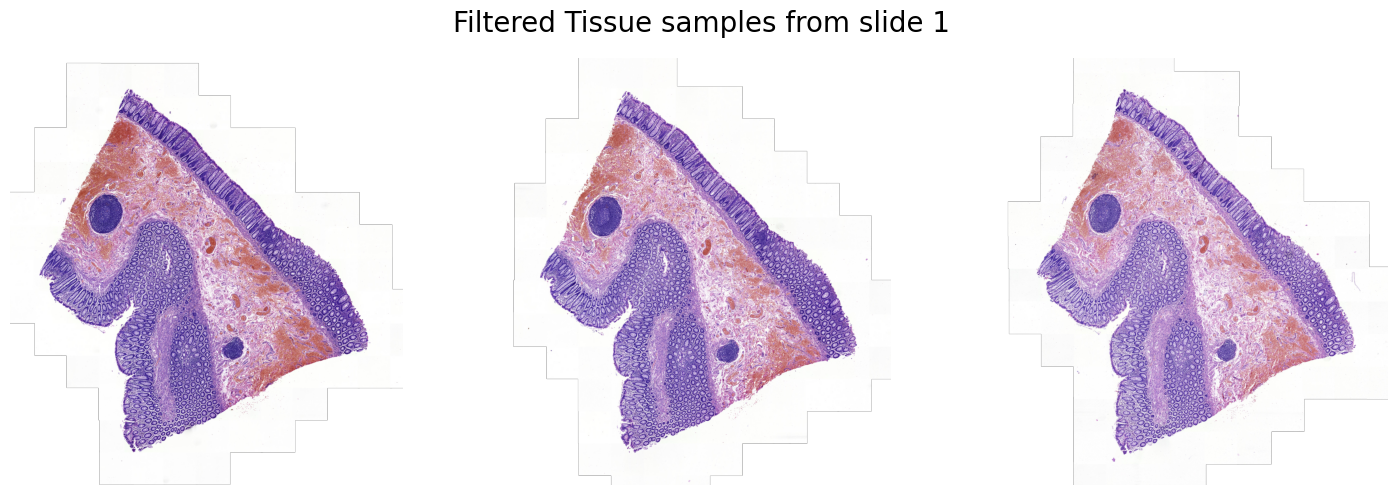

Filtered 3 small samples (threshold: 151638)


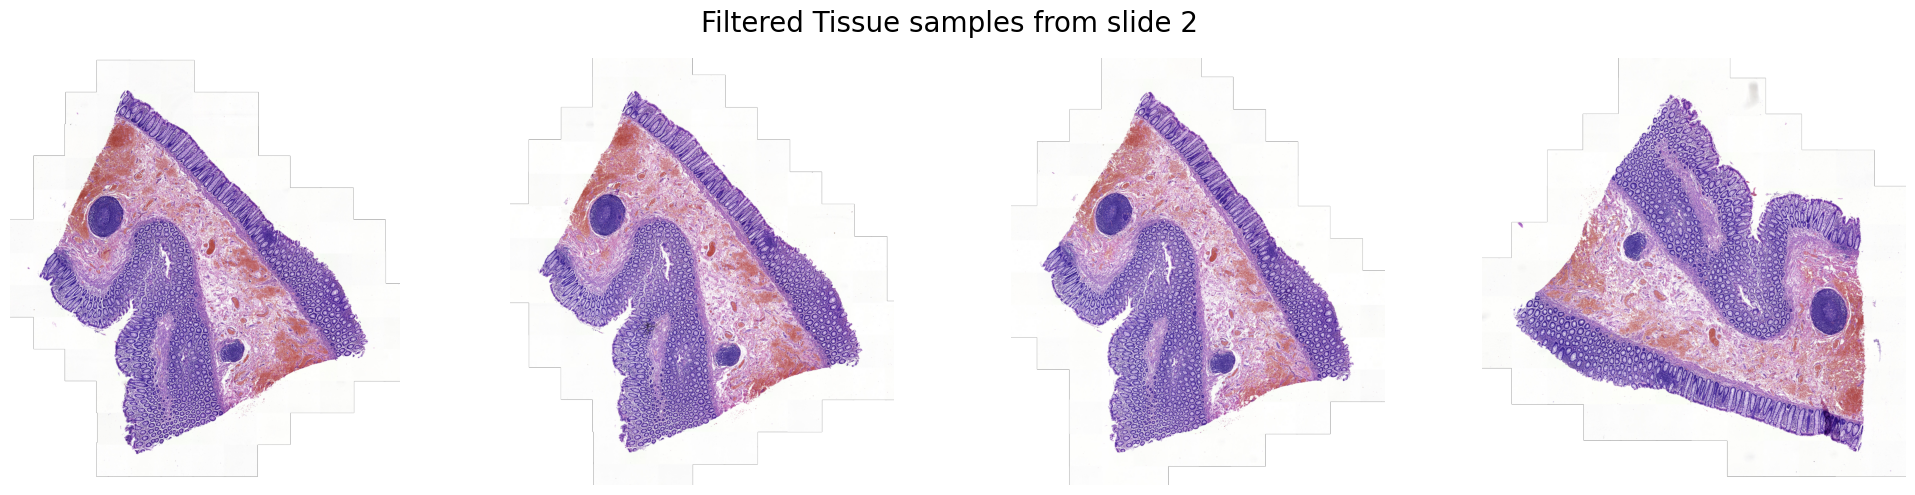

In [4]:
def filter_tissue_samples_by_area(slide_tissues, max_prc=0.2):
    if len(slide_tissues) <= 1:
        return slide_tissues

    areas = [img.shape[0] * img.shape[1] for img in slide_tissues]

    sorted_indices = sorted(range(len(areas)), key=lambda i: areas[i], reverse=True)

    smallest_prc = np.inf
    index = 0
    for i in range(1, len(sorted_indices)):
        a1 = areas[sorted_indices[i-1]]
        a2 = areas[sorted_indices[i]]
        prc = a2 / a1

        if prc < smallest_prc:
            smallest_prc = prc
            index = i

    if smallest_prc < max_prc:
        threshold = areas[sorted_indices[index]]
        filtered = [img for img in slide_tissues if img.shape[0] * img.shape[1] > threshold]
        print(f"Filtered {len(slide_tissues) - len(filtered)} small samples (threshold: {threshold})")
        return filtered
    else:
        print("No filtering applied")
        return slide_tissues
    
for i in range(len(tissue)):
    tissue[i] = filter_tissue_samples_by_area(
        tissue[i],
        max_prc=0.2
    )

    fig, axes = plt.subplots(1,len(tissue[i]), figsize=(5*len(tissue[i]), 5))
    fig.suptitle(f'Filtered Tissue samples from slide {i+1}', fontsize=20)
    
    if len(tissue[i]) == 1:
        axes = [axes]

    for j in range(len(tissue[i])):
        axes[j].imshow(tissue[i][j])
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

**Figure:** Tissue samples after area-based filtering, showing only the largest and most relevant fragments from each slide. This visualization confirms effective removal of artifacts from slide image.

## Channel reductions

### Remove Alpha

This code handles tissue image samples with an additional WSI info channel. For each image with 4 channels, it replaces fully transparent pixels (tissue is not present there) with white background to standardize the appearance.

Image[0][0] - Min alpha: 0, Max alpha: 255
Image[0][1] - Min alpha: 0, Max alpha: 255
Image[0][2] - Min alpha: 0, Max alpha: 255
Image[1][0] - Min alpha: 0, Max alpha: 255
Image[1][1] - Min alpha: 0, Max alpha: 255
Image[1][2] - Min alpha: 0, Max alpha: 255
Image[1][3] - Min alpha: 0, Max alpha: 255


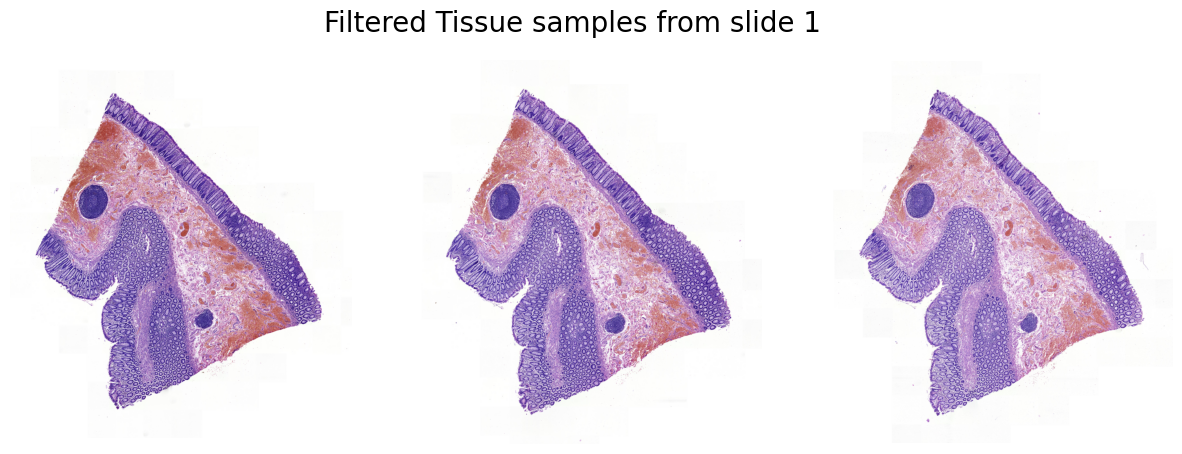

In [5]:
for i in range(len(tissue)):
    for j in range(len(tissue[i])):
        img = tissue[i][j]
        if img.shape[-1] == 4:
            rgb = img[:, :, :3].copy()
            alpha = img[:, :, 3]
            print(f"Image[{i}][{j}] - Min alpha: {alpha.min()}, Max alpha: {alpha.max()}")
            mask = (alpha == 0)
            rgb[mask] = 255
            tissue[i][j] = rgb

i = 0
fig, axes = plt.subplots(1,len(tissue[i]), figsize=(5*len(tissue[i]), 5))
fig.suptitle(f'Filtered Tissue samples from slide {i+1}', fontsize=20)

if len(tissue[i]) == 1:
    axes = [axes]

for j in range(len(tissue[i])):
    axes[j].imshow(tissue[i][j])
    axes[j].axis('off')

**Figure:** Tissue samples from the first slide after additional channel removal, with full-background areas replaced by white.

## Masking

This code generates binary masks to isolate tissue areas within each extracted tissue sample. It converts images to grayscale, applies thresholding, and uses morphological closing to clean the mask. Flood fill removes background holes, and connected components analysis selects the largest contiguous tissue region.

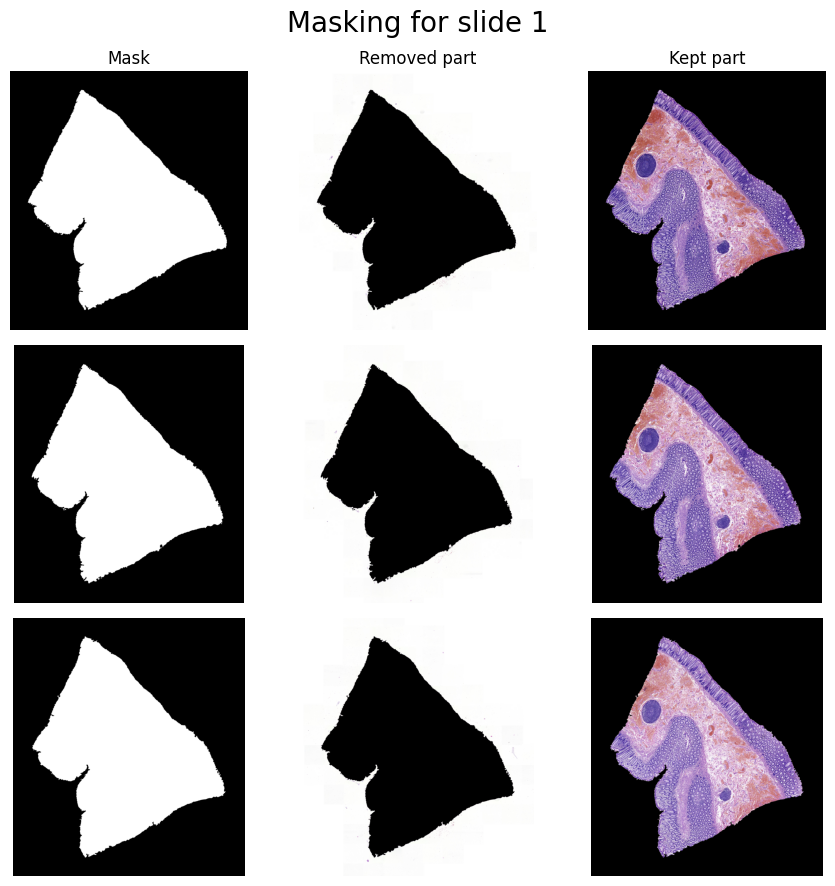

In [6]:
slide_vis_index = 0

masks = []

for i in range(len(tissue)):
    masks.append([])
    for j in range(len(tissue[i])):
        gray = cv2.cvtColor(tissue[i][j], cv2.COLOR_RGB2GRAY)
        mask = (gray < 200).astype(np.uint8)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        floodfilled = closed_mask.copy()
        h, w = closed_mask.shape
        mask_floodfill = np.zeros((h+2, w+2), np.uint8)

        cv2.floodFill(floodfilled, mask_floodfill, (0,0), 255)
        floodfilled_inv = cv2.bitwise_not(floodfilled)
        filled_mask = closed_mask | floodfilled_inv

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filled_mask, connectivity=8)
        if num_labels > 1:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            largest_mask = (labels == largest_label).astype(np.uint8)
        else:
            largest_mask = filled_mask

        masks[i].append(largest_mask.astype(bool))
        
n = len(tissue[slide_vis_index])
fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
fig.suptitle(f'Masking for slide {slide_vis_index + 1}', fontsize=20)
if n == 1:
    axes = [axes]

for i, (t, mask) in enumerate(zip(tissue[slide_vis_index], masks[slide_vis_index])):
    axes[i,0].imshow(mask, cmap='gray')
    if i == 0:
        axes[i,0].set_title('Mask')
    
    removed = t.copy()
    removed[mask] = 0
    axes[i,1].imshow(removed)
    if i == 0:
        axes[i,1].set_title('Removed part')

    kept = t.copy()
    kept[~mask] = 0
    axes[i,2].imshow(kept)
    if i == 0:
        axes[i,2].set_title('Kept part')

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

**Figure:** Visualization of tissue masking steps for the first slide. Left: binary tissue masks; middle: image areas removed by the mask (set to zero); right: retained tissue regions.

## Color Deconvolution

This code performs color deconvolution on extracted tissue samples to separate Hematoxylin and Eosin stain components using the HED color space. It applies masks to exclude background regions, normalizes the stain intensities, and calculates average dynamic ranges for both stains across samples.

Avg. Eosine dynamic range: 0.0, 0.7487909499637938
Avg. Hematoxylin dynamic range: 0.0, 0.2753872483272684
Avg. Eosine dynamic range: 0.0, 0.621854702654598
Avg. Hematoxylin dynamic range: 0.0, 0.2899787493034269


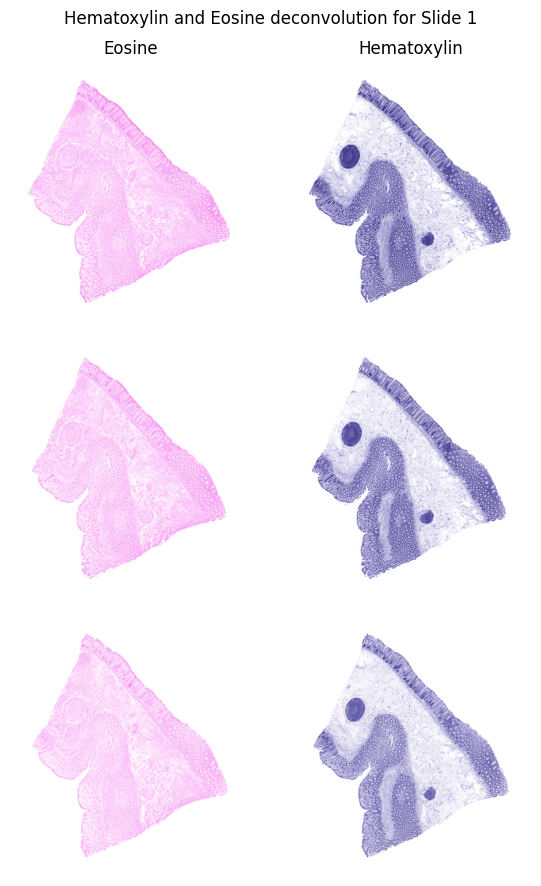

In [7]:
tissue_vis_index = 0

def vis_deconv(he):
    null = np.zeros_like(he[:, :, 0])
    hem_rgb = hed2rgb(np.stack((he[:, :, 0], null, null), axis=-1))
    eos_rgb = hed2rgb(np.stack((null, he[:, :, 1], null), axis=-1))

    return hem_rgb, eos_rgb

stain_matrix = hed_from_rgb 

tissue_he = []

for i in range(len(tissue)):
    tissue_he.append([]) 

    eos_dynamic_range = [0, 0]
    hem_dynamic_range = [0, 0]
    n = len(tissue[i])
    for j in range(n):
        img = tissue[i][j]
        img = img.astype(np.float32) / 255.0

        img[~masks[i][j]] = 1
        deconv = rgb2hed(img)
        he = deconv[...,:2]

        eos_dynamic_range[0] += he[...,1].min() / n
        eos_dynamic_range[1] += he[...,1].max() / n
        hem_dynamic_range[0] += he[...,0].min() / n
        hem_dynamic_range[1] += he[...,0].max() / n

        tissue_he[i].append(he)

    print(f'Avg. Eosine dynamic range: {eos_dynamic_range[0]}, {eos_dynamic_range[1]}')
    print(f'Avg. Hematoxylin dynamic range: {hem_dynamic_range[0]}, {hem_dynamic_range[1]}')

cols = len(tissue_he[tissue_vis_index])
fig, axes = plt.subplots(cols, 2, figsize=(6, cols*3))
fig.suptitle(f'Hematoxylin and Eosine deconvolution for Slide {tissue_vis_index + 1}')
axes[0,0].set_title('Eosine')
axes[0,1].set_title('Hematoxylin')
for i, he in enumerate(tissue_he[tissue_vis_index]):
    hem_rgb, eos_rgb = vis_deconv(he)

    axes[i,0].imshow(eos_rgb)
    axes[i,0].axis('off')
    axes[i,1].imshow(hem_rgb)
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()

**Figure:** Visualization of Hematoxylin and Eosin stain components after color deconvolution for tissue samples from the first slide. Left column shows Eosin, right column shows Hematoxylin. We can observe that images esspecially Eosine lacks intensity.

## CLAHE Enchacement and normalization

This code applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to normalize and enhance the contrast of Hematoxylin and Eosin channels obtained from stain deconvolution. The contrast enhancement is applied only within tissue regions defined by masks, improving visibility of each deconvoluted channel.

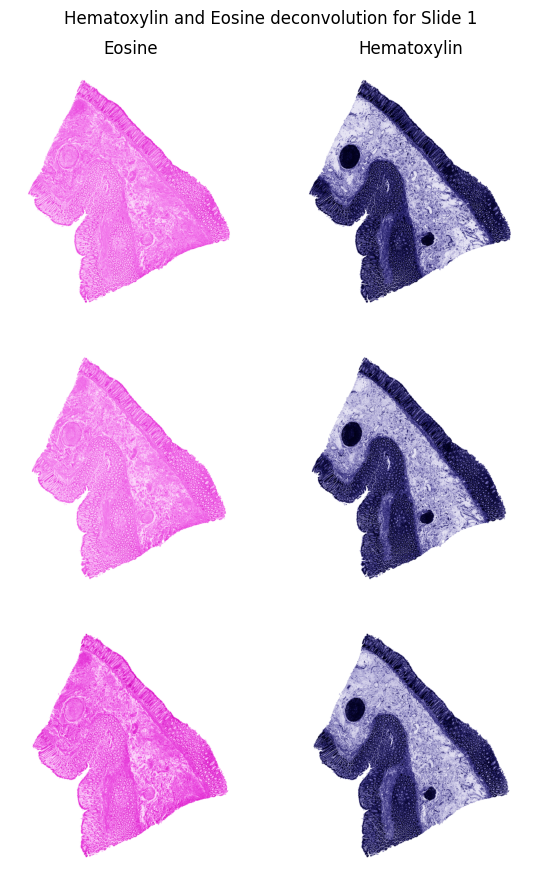

In [8]:
tissue_vis_index = 0

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for i, (slide_he, slide_masks) in enumerate(zip(tissue_he, masks)):
    for j, (he, mask) in enumerate(zip(slide_he, slide_masks)):
        he_norm = np.zeros_like(he, dtype=np.uint8)
        he_norm[...,0] = cv2.normalize((he[...,0] * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX)
        he_norm[...,1] = cv2.normalize((he[...,1] * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX)
        he_norm[...,0] = clahe.apply(he_norm[...,0])
        he_norm[...,1] = clahe.apply(he_norm[...,1])
        he_norm[~mask] = 0

        tissue_he[i][j] = he_norm

cols = len(tissue_he[tissue_vis_index])
fig, axes = plt.subplots(cols, 2, figsize=(6, cols*3))
fig.suptitle(f'Hematoxylin and Eosine deconvolution for Slide {tissue_vis_index + 1}')
axes[0,0].set_title('Eosine')
axes[0,1].set_title('Hematoxylin')
for i, he in enumerate(tissue_he[tissue_vis_index]):
    hem_rgb, eos_rgb = vis_deconv(he)

    axes[i, 0].imshow(eos_rgb)
    axes[i, 1].imshow(hem_rgb)
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

**Figure:** Contrast enhanced Hematoxylin and Eosin stain components for tissue samples from the first slide.

## Save processed

The code below serializes processed tissues ino pickle files for further processing in next steps.

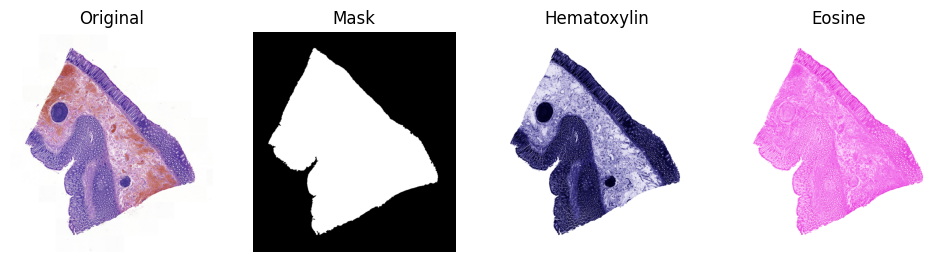

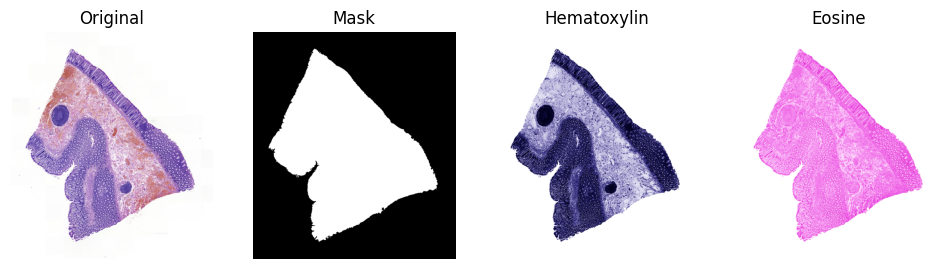

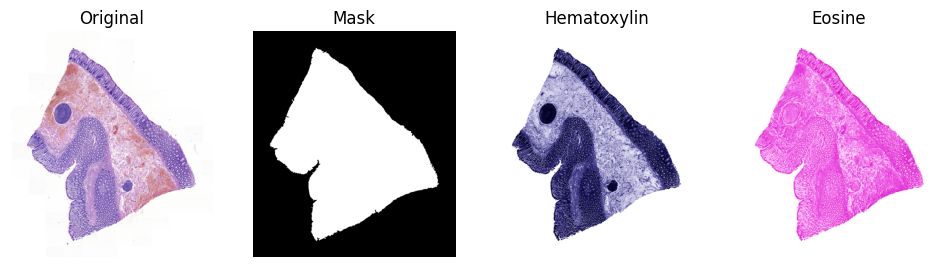

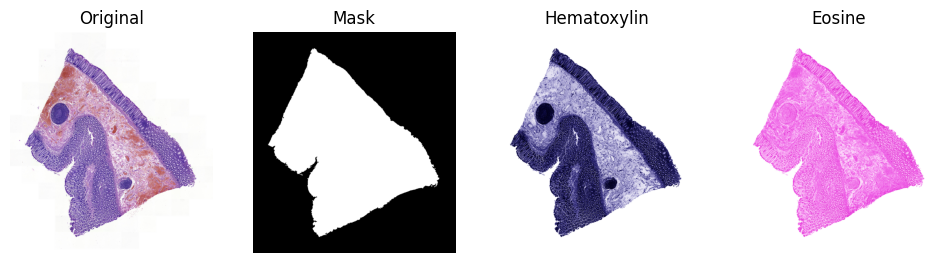

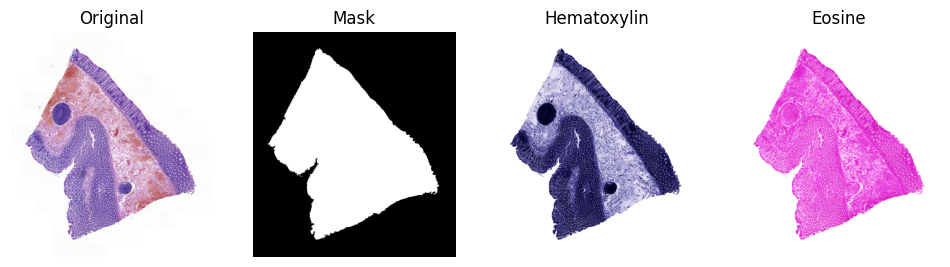

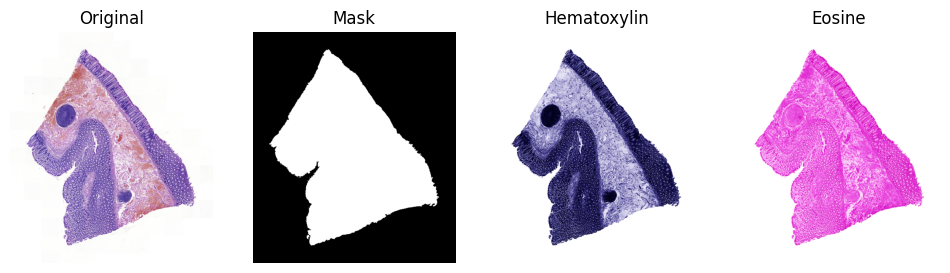

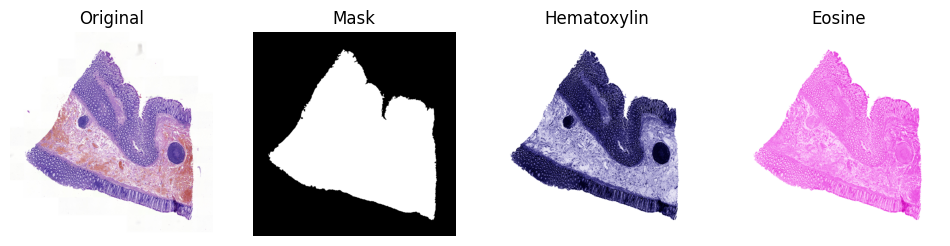

In [ ]:
save_path = '../data/'
os.makedirs(save_path, exist_ok=True)

slide_dir = '../data/WSI_scans/'

slides_filepaths = ['1M01.mrxs', '1M02.mrxs']

for i in range(len(slides_filepaths)):
    slides_filepaths[i] = slide_dir + slides_filepaths[i]

for i in range(len(tissue)):
    slide = Slide(
        lod=lod,
        filepath=slides_filepaths[i],
        thumbnail=thumbnail[i]
    )
    for j in range(len(tissue[i])):
        t = Tissue(
            he=tissue_he[i][j],
            rgb=tissue[i][j],
            mask=masks[i][j]
        )

        t.quick_plot()
        slide.append(t)
    
    with open(save_path + f'slide_{i+1}.pkl', 'wb') as f:
        pickle.dump(slide, f)